# Install Modules

In [1]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install pydot
%pip install graphviz
%pip install tensorflow
%pip install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img  # Use tf.keras.preprocessing.image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [4]:
BASE_DIR = '/content/drive/MyDrive/UTKFace'

In [5]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/3578 [00:00<?, ?it/s]

In [6]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/drive/MyDrive/UTKFace/1_1_3_201612202...,1,1
1,/content/drive/MyDrive/UTKFace/1_1_3_201612201...,1,1
2,/content/drive/MyDrive/UTKFace/20_0_2_20170117...,20,0
3,/content/drive/MyDrive/UTKFace/1_1_3_201612192...,1,1
4,/content/drive/MyDrive/UTKFace/1_1_2_201701091...,1,1


In [7]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

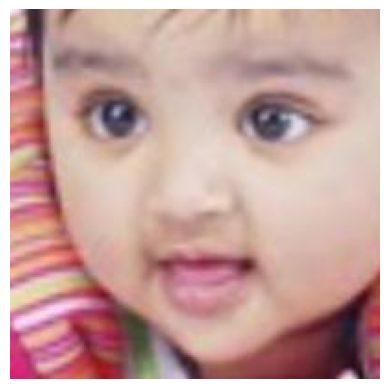

In [8]:
from PIL import Image
img = Image.open(df['image'][10])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

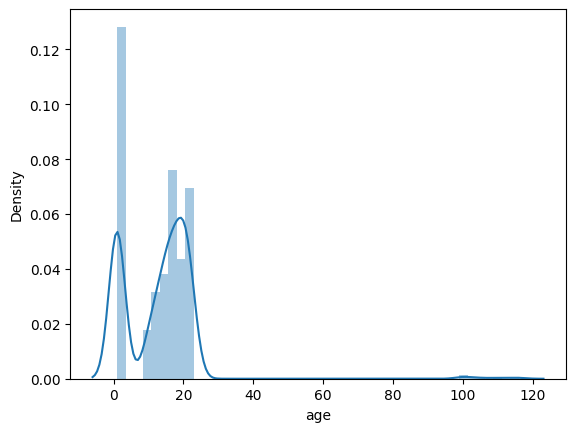

In [9]:
sns.distplot(df['age'])

Text(0.5, 1.0, 'Distribution of Gender')

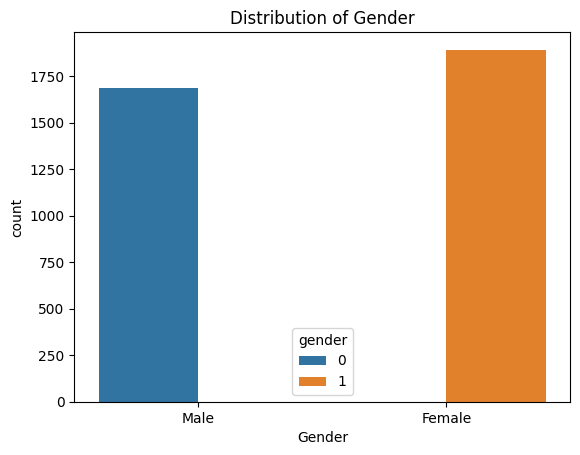

In [10]:
# This line of code is not working it is only showing the total number of images in a form
# of a single column. So i used the updated code below.
# sns.countplot(df['gender'])


# Read the usage of hue in below code for future reference
# By adding the hue='gender' parameter to sns.countplot, it will separate the bars
# by gender (0 for Male, 1 for Female) and display them in different colors.

sns.countplot(x='gender', data=df, hue='gender')
plt.xlabel("Gender")
plt.xticks([0, 1], labels=["Male", "Female"])
plt.title("Distribution of Gender")

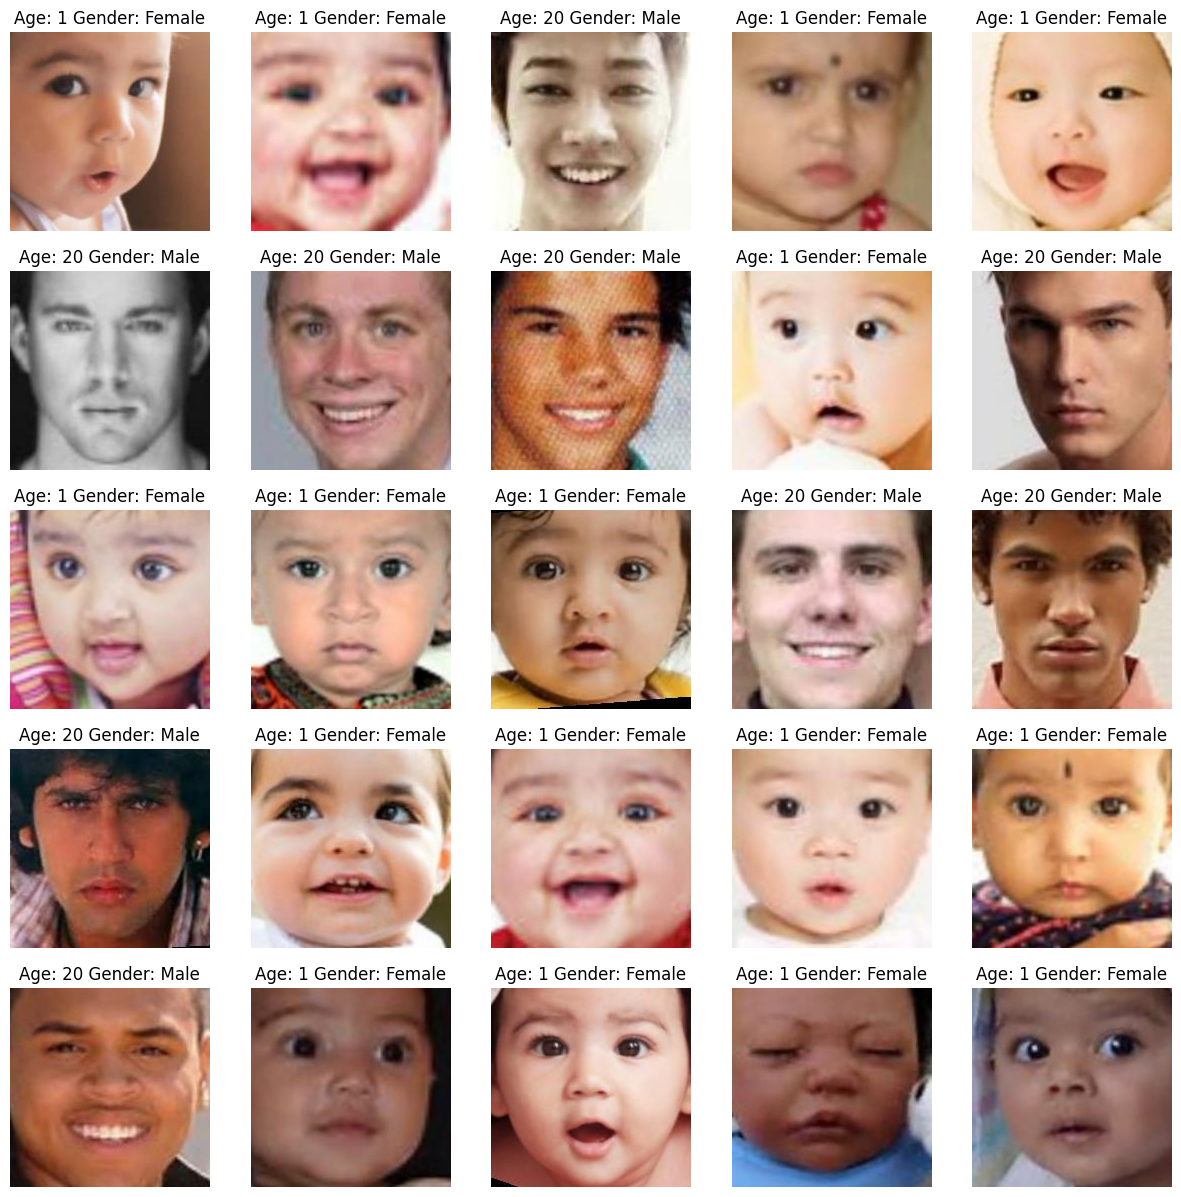

In [11]:
# to display grid of images
plt.figure(figsize=(15, 15))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:
X = extract_features(df['image'])

  0%|          | 0/3578 [00:00<?, ?it/s]

In [14]:
X.shape

(3578, 128, 128, 1)

In [15]:
# normalize the images
X = X/255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape = (128, 128, 1)

## Model Creation

In [18]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

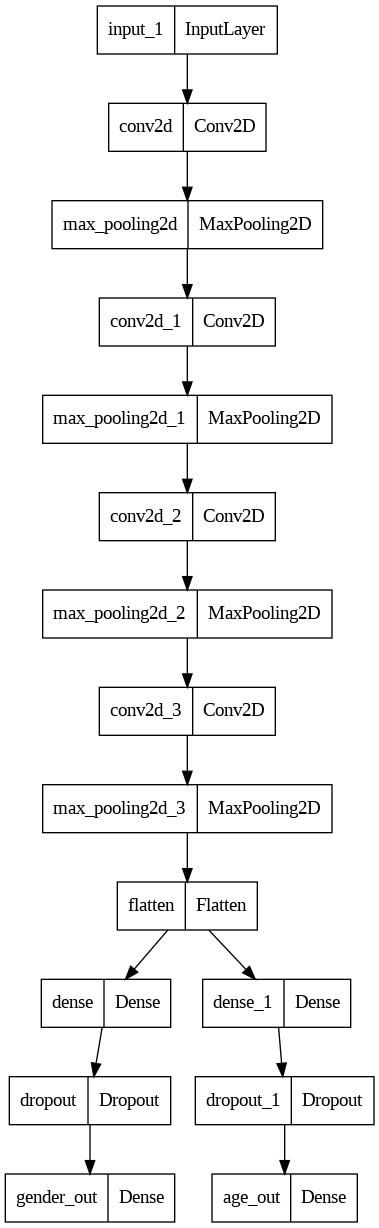

In [19]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
90/90 [==============================] - 12s 41ms/step - loss: 8.6505 - gender_out_loss: 0.6970 - age_out_loss: 7.9535 - gender_out_accuracy: 0.5405 - age_out_accuracy: 0.3735 - val_loss: 9.4031 - val_gender_out_loss: 0.6496 - val_age_out_loss: 8.7536 - val_gender_out_accuracy: 0.5852 - val_age_out_accuracy: 0.0531
Epoch 2/15
90/90 [==============================] - 2s 20ms/step - loss: 4.6333 - gender_out_loss: 0.6418 - age_out_loss: 3.9915 - gender_out_accuracy: 0.6338 - age_out_accuracy: 0.3222 - val_loss: 8.8415 - val_gender_out_loss: 0.6093 - val_age_out_loss: 8.2322 - val_gender_out_accuracy: 0.6746 - val_age_out_accuracy: 0.0545
Epoch 3/15
90/90 [==============================] - 2s 22ms/step - loss: 3.5869 - gender_out_loss: 0.6101 - age_out_loss: 2.9768 - gender_out_accuracy: 0.6586 - age_out_accuracy: 0.3557 - val_loss: 7.7032 - val_gender_out_loss: 0.5954 - val_age_out_loss: 7.1078 - val_gender_out_accuracy: 0.6746 - val_age_out_accuracy: 0.0545
Epoch 4/15
90/90 [

## Plot the Results

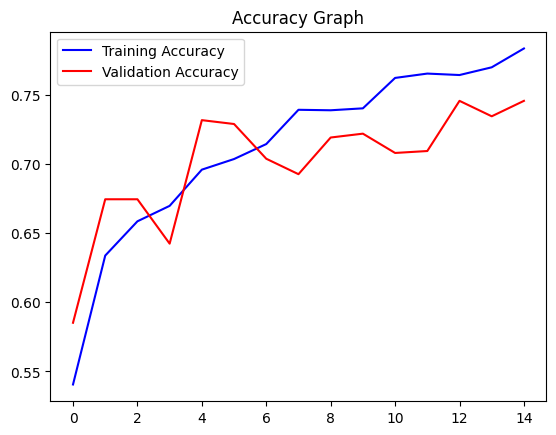

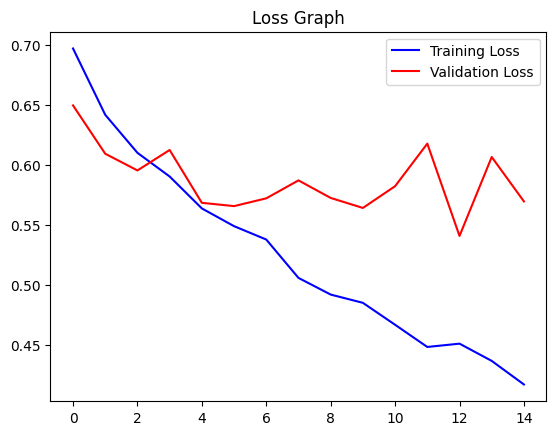

In [21]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

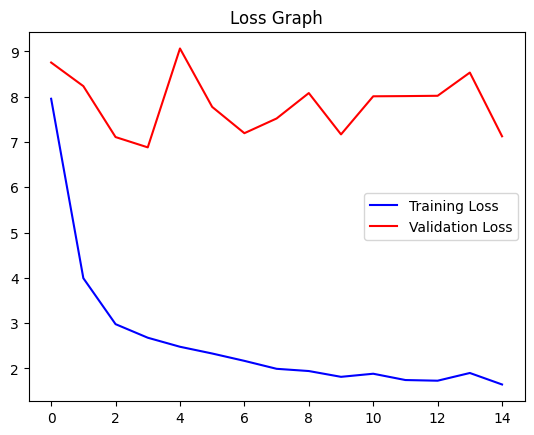

In [22]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 1
1/1 [==============================] - 0s 289ms/step
Predicted Gender: Female Predicted Age: 1


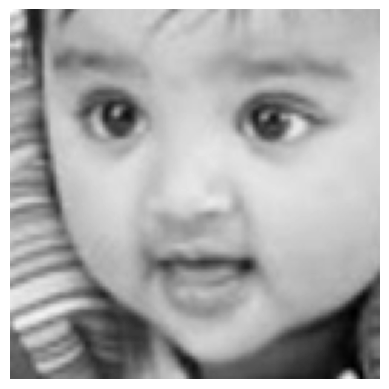

In [23]:
image_index = 10
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 20
1/1 [==============================] - 0s 30ms/step
Predicted Gender: Female Predicted Age: 20


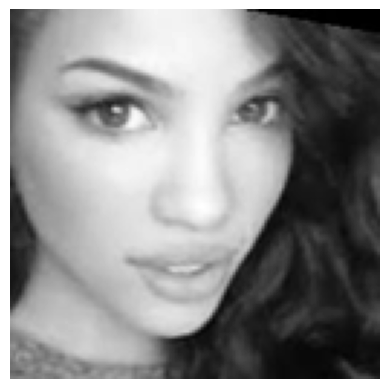

In [24]:
image_index = 300
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 17
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: 15


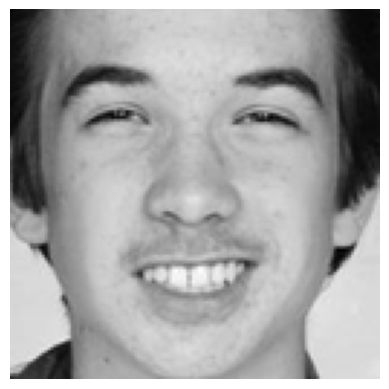

In [25]:
image_index = 2500
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 17
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Female Predicted Age: 18


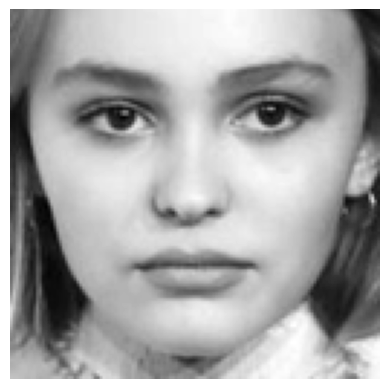

In [26]:
image_index = 2567
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 1
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Male Predicted Age: 1


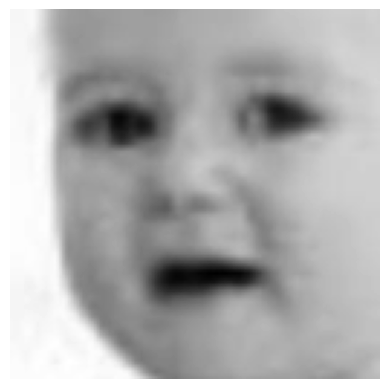

In [28]:
image_index = 1577
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');